In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
g_palette = glasbey.create_palette()
blue_palette = sns.cubehelix_palette(5, rot=-.25, light=.7)

In [3]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadata, tracklets_joined = import_tracklets(datapath, roots)

In [4]:
root = "embryo018"
color_img = tifffile.imread(datapath / root / f"{root}_lineages_light.tif")
label_img = tifffile.imread(datapath / root / f"{root}_lineages.tif")

track_n_tracklets
1.0     696
31.0     58
3.0      29
7.0      26
15.0     14
5.0      11
9.0       6
23.0      4
29.0      4
13.0      4
27.0      3
19.0      3
17.0      2
11.0      2
25.0      1
Name: count, dtype: int64
#93d4ff
[147 212 255]


100%|██████████| 1360/1360 [00:01<00:00, 747.66it/s]


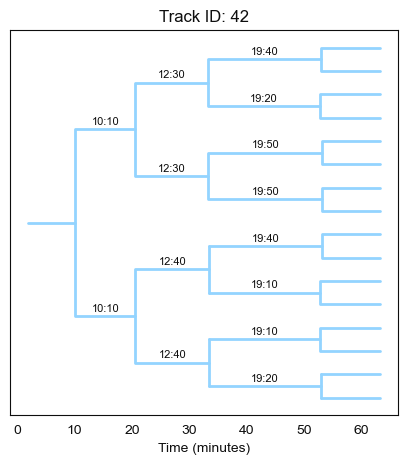

In [5]:
from src.utils import get_tracklet_tree, visualize_tracklet_tree

### manually selected trees
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

spot = spots[root]
print(spot.groupby("track_id")["track_n_tracklets"].mean().value_counts())
spot = spot[spot["track_n_tracklets"] == 31]
tid = spot["track_id"].unique()[25]
spot = spot[spot["track_id"] == tid]
spot_x, spot_y, spot_frame = spot["POSITION_X"].iloc[0], spot["POSITION_Y"].iloc[0], spot["FRAME"].iloc[0]

color = color_img[int(spot_frame)][int(spot_y)][int(spot_x)]
color_rgb = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
print(color_rgb)

tracklet = tracklets[root]
tree = get_tracklet_tree(tracklet[tracklet["track_id"] == tid])

ax.set_xlabel("Time (minutes)")
ax.set_title(f"Track ID: {tid}")

visualize_tracklet_tree(tree, ax, c=color_rgb)

plt.savefig(plotpath / f"{root}_{tid}_tracklet_tree.png", dpi=300)
print(color)
final_frame = color_img[-1].copy()
# erase all but the selected tracklet
for y in tqdm(range(final_frame.shape[0])):
    for x in range(final_frame.shape[1]):
        if final_frame[y, x, 0] != color[0] or final_frame[y, x, 1] != color[1] or final_frame[y, x, 2] != color[2]:
            final_frame[y, x] = [255, 255, 255]


tifffile.imwrite(plotpath / f"{root}_{tid}_final_frame.tif", final_frame)

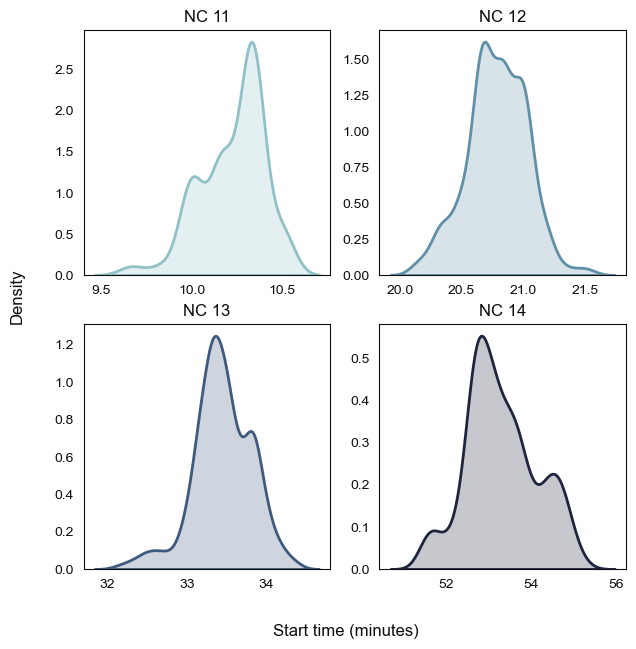

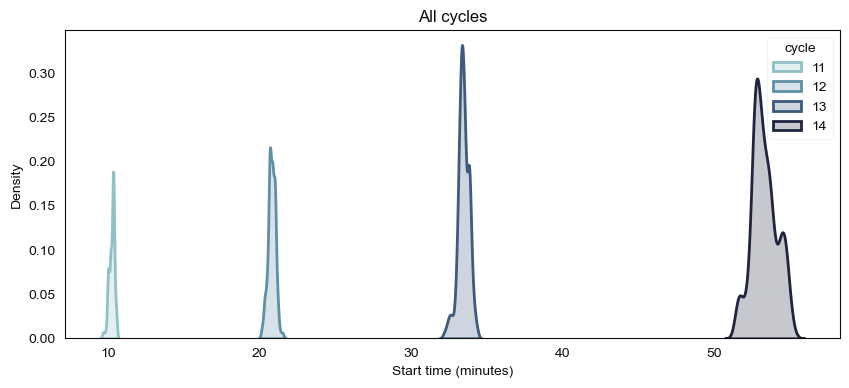

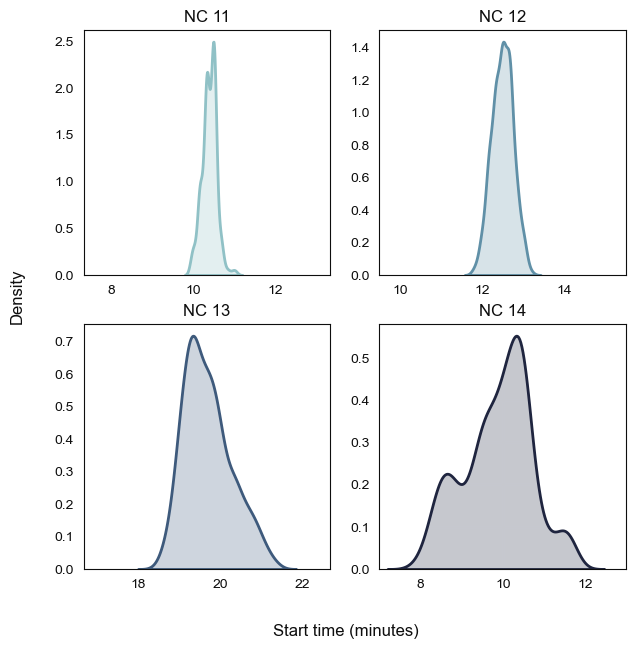

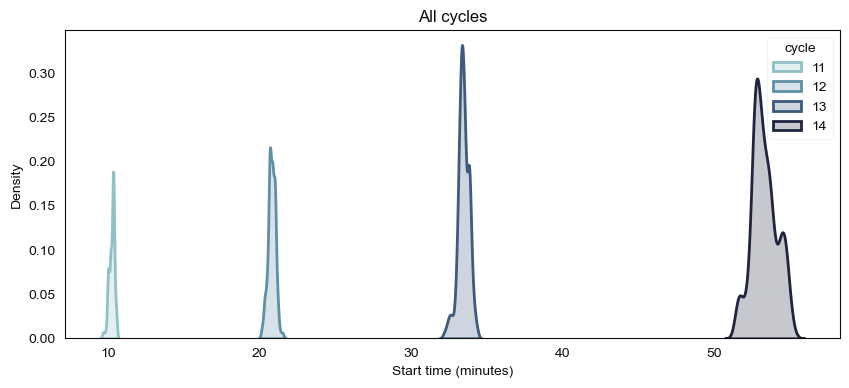

In [6]:
tracklet = tracklets[root]
tracklet = tracklet[tracklet["track_n_tracklets"] == 31]
tracklet = tracklet[tracklet["cycle"].isin([11, 12, 13, 14])]
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

fig, axes = plt.subplots(2, 2, figsize=(7, 7))
# plt.tight_layout()
for cycle, ax in zip([11, 12, 13, 14], axes.flatten()):
    # fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
    # ax.set_title(f"Cycle {cycle}")
    color = pal[(cycle - 11)]
    sns.kdeplot(data=tracklet[tracklet["cycle"]==cycle], x="start_time", color=color, fill=True, linewidths=2, ax=ax)
    ax.set_title(f"NC {cycle}")
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.supxlabel("Start time (minutes)")
fig.supylabel("Density")
plt.savefig(plotpath / f"{root}_cycle_{cycle}_start_time.png", dpi=300)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_xlabel("Start time (minutes)")
ax.set_title("All cycles")
sns.kdeplot(data=tracklet, x="start_time", hue="cycle", fill=True, linewidths=2, ax=ax, palette=pal)

plt.savefig(plotpath / f"{root}_all_cycles_start_time.png", dpi=300)

tifffile.imwrite(plotpath / f"{root}_{tid}_final_frame.tif", final_frame)
tracklet = tracklets[root]
tracklet = tracklet[tracklet["track_n_tracklets"] == 31]
tracklet = tracklet[tracklet["cycle"].isin([11, 12, 13, 14])]
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

fig, axes = plt.subplots(2, 2, figsize=(7, 7))
# plt.tight_layout()
for cycle, ax in zip([11, 12, 13, 14], axes.flatten()):
    # fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
    # ax.set_title(f"Cycle {cycle}")
    color = pal[(cycle - 11)]
    t = tracklet[tracklet["cycle"] == cycle]
    sns.kdeplot(data=t, x="length", color=color, fill=True, linewidths=2, ax=ax)
    xmin, xmax = t["length"].median() - 3, t["length"].median() + 3
    ax.set_xlim(xmin, xmax)
    ax.set_title(f"NC {cycle}")
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.supxlabel("Start time (minutes)")
fig.supylabel("Density")
plt.savefig(plotpath / f"{root}_cycle_{cycle}_start_time.png", dpi=300)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_xlabel("Start time (minutes)")
ax.set_title("All cycles")
sns.kdeplot(data=tracklet, x="start_time", hue="cycle", fill=True, linewidths=2, ax=ax, palette=pal)

plt.savefig(plotpath / f"{root}_all_cycles_start_time.png", dpi=300)

    
    # plt.savefig(plotpath / f"{root}_cycle_{cycle}_tracklet_tree.png", dpi=300)

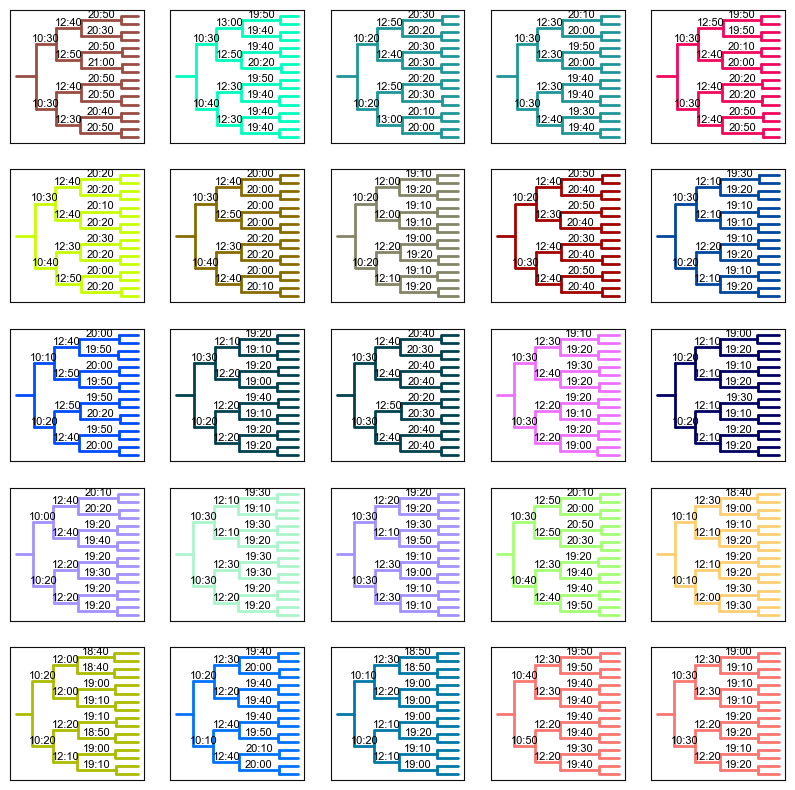

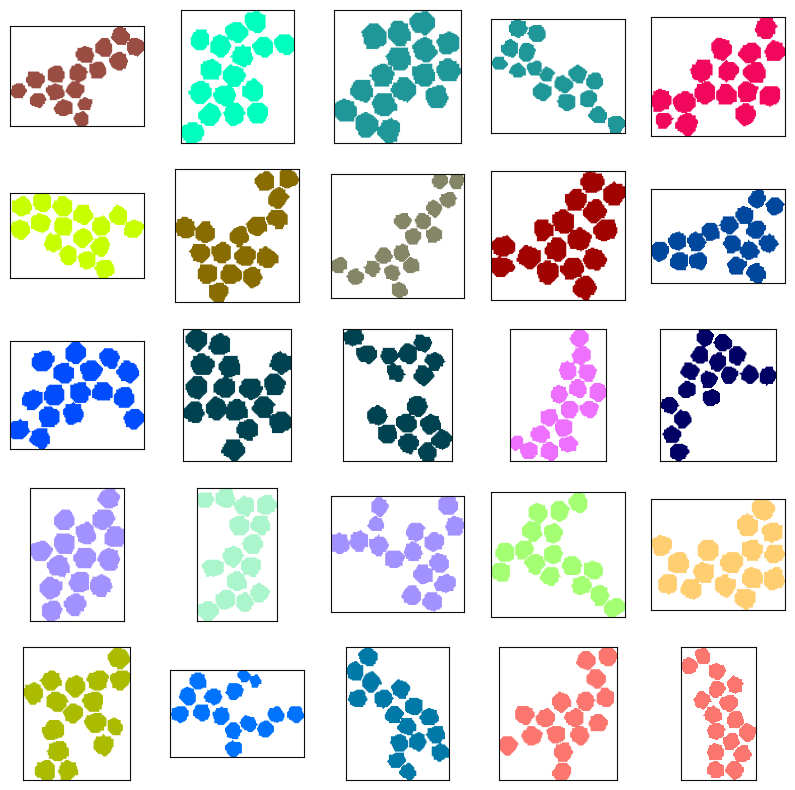

In [13]:
from skimage.measure import regionprops

props = regionprops(label_img[-1], intensity_image=color_img[-1])
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

spot = spots[root]
spot = spot[spot["track_n_tracklets"] == 31]
tracks = spot["track_id"].unique()

for track, ax in zip(tracks, axes.flatten()):
    tracklet = tracklets[root]
    tree = get_tracklet_tree(tracklet[tracklet["track_id"] == track])
    color = props[track].mean_intensity
    color = [round(c) for c in color]
    color_rgb = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
    visualize_tracklet_tree(tree, ax, c=color_rgb)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(plotpath / f"{root}_tracklet_trees.png", dpi=300)
plt.show()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for track, ax in zip(tracks, axes.flatten()):
    tracklet = tracklets[root]
    # set all black pixels to white
    indices = np.where(np.sum(props[track].image_intensity, axis=2) == 0)
    props[track].image_intensity[indices] = [255, 255, 255]
    ax.imshow(props[track].image_intensity)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(plotpath / f"{root}_tracklets.png", dpi=300)
plt.show()

fullprops = [props[t] for t in tracks]


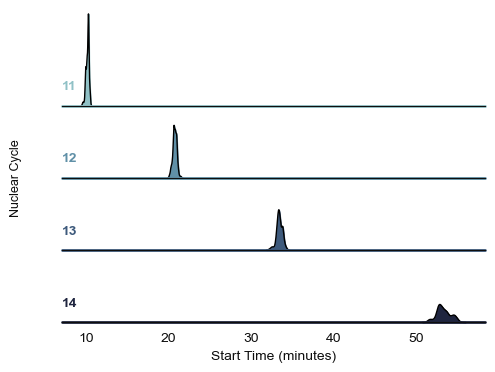

In [133]:
rcParams.update({"axes.grid" : False, "grid.color": "black"})

tracklet = tracklet[tracklet["cycle"].isin([11, 12, 13, 14])]
tracklet = tracklet[tracklet["track_n_tracklets"] == 31]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
g = sns.FacetGrid(tracklet, row="cycle", hue="cycle", aspect=5, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "start_time",
      clip_on=False,
      fill=True, alpha=1, linewidth=.75)
g.map(sns.kdeplot, "start_time", clip_on=False, color="k", lw=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "start_time")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine( left=True)


g.figure.supylabel("Nuclear Cycle", fontsize=9)
g.axes[-1, 0].set_xlabel("Start Time (minutes)")

plt.savefig(plotpath / f"{root}_length_kde.png", dpi=300)

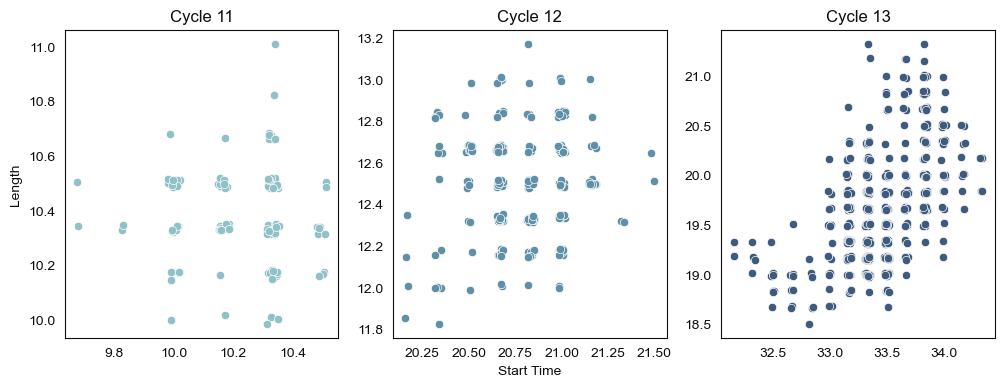

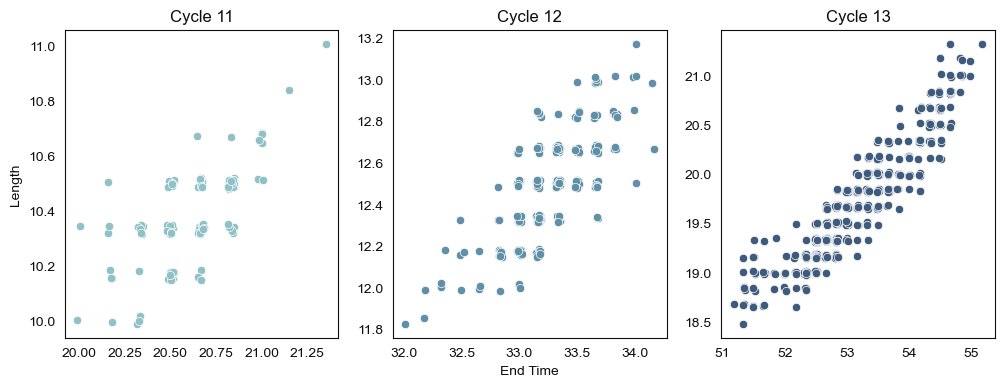

In [155]:
def jitter(values, jitter=0.5):
    n = len(values)
    return values + np.random.uniform(-jitter, jitter, n)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# plt.tight_layout()
for cycle, ax in zip([11, 12, 13], axes):
    ax.set_title(f"Cycle {cycle}")
    t = tracklet[tracklet["cycle"] == cycle]
    color = pal[(cycle - 11)]
    sns.scatterplot(x=jitter(t["start_time"], 0.02), y=jitter(t["length"], 0.02), color=color, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
axes[1].set_xlabel("Start Time")
axes[0].set_ylabel("Length")
plt.savefig(plotpath / f"{root}_length_start_time.png", dpi=300)
    
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# plt.tight_layout()
for cycle, ax in zip([11, 12, 13], axes):
    ax.set_title(f"Cycle {cycle}")
    t = tracklet[tracklet["cycle"] == cycle]
    color = pal[(cycle - 11)]
    sns.scatterplot(x=jitter(t["end_time"], 0.02), y=jitter(t["length"], 0.02), color=color, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
axes[1].set_xlabel("End Time")
axes[0].set_ylabel("Length")
plt.savefig(plotpath / f"{root}_length_end_time.png", dpi=300)

In [15]:
print(spots[roots[0]].columns)
print(tracklets[roots[0]].columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle'],
      dtype='object')
Index(['start_time', 'end_time', 'start_frame', 'end_frame', 'length',
       'source_spot', 'sink_spot', 'mean_ap_position', 'source_ap_position',
       'sink_ap_position', 'initial_x', 'initial_y', 'final_x', 'final_y',
       'initial_x_um', 'initial_y_um', 'final_x_um', 'final_y_um', 'track_id',
       'mean_edge_distance', 'track_n_tracklets', 'cycle', 'embryo',
       'tracklet_id', 'parent_tracklet', 'n_children', 'e_id', 'e_parent_id'],
      dtype='object')


In [8]:
# approx 25s total

ft_spots = {}

for root in roots:
    spot = spots[root]
    ft_spot = spot[spot["track_n_tracklets"] == 31].copy()
    
    rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
    raw = tifffile.imread(rawfile)
    shape = raw.shape
    
    ft_spot["intensity_mean"] = np.nan
    ft_spot["normed_intensity_mean"] = np.nan
    
    for cycle in [11, 12, 13]:
        ft_cycle = ft_spot[ft_spot["cycle"] == cycle].copy()
        print(f"Root: {root}, Cycle: {cycle}, Number of spots: {ft_cycle.shape[0]}") 
        
        for idx, spot in ft_cycle.iterrows():
            x, y = spot["POSITION_X"], spot["POSITION_Y"]
            t = round(spot["FRAME"])
            new_track_id = spot["track_id"]
            
            roi = [float(pt.lstrip("[ ").rstrip("] ")) for pt in spot["roi"].split(",")]
        
            xs = [round(pt + x) for pt in roi[::2]]
            ys = [round(pt + y) for pt in roi[1::2]]
        
            rr, cc = polygon(ys, xs, shape[1:])
            intensity_vals = raw[tuple([t] + [rr, cc])]
            
            ft_cycle.loc[idx, "intensity_mean"] = intensity_vals.mean()
       
        x = ft_cycle["intensity_mean"]
        ft_cycle["normed_intensity_mean"] = (x - x.mean()) / x.std()
        ft_spot[ft_spot["cycle"] == cycle] = ft_cycle
       
    ft_spots[root] = ft_spot     
    
        
        

Root: embryo007, Cycle: 11, Number of spots: 3573
Root: embryo007, Cycle: 12, Number of spots: 7332
Root: embryo007, Cycle: 13, Number of spots: 21365
Root: embryo008, Cycle: 11, Number of spots: 3002
Root: embryo008, Cycle: 12, Number of spots: 7047
Root: embryo008, Cycle: 13, Number of spots: 20462
Root: embryo014a, Cycle: 11, Number of spots: 4227
Root: embryo014a, Cycle: 12, Number of spots: 9963
Root: embryo014a, Cycle: 13, Number of spots: 28724
Root: embryo016, Cycle: 11, Number of spots: 6086
Root: embryo016, Cycle: 12, Number of spots: 14651
Root: embryo016, Cycle: 13, Number of spots: 45512
Root: embryo018, Cycle: 11, Number of spots: 7347
Root: embryo018, Cycle: 12, Number of spots: 17621
Root: embryo018, Cycle: 13, Number of spots: 55265


In [16]:
for root in roots:
    ft_spots[root]["normed_area"] = (ft_spots[root]["AREA"] - ft_spots[root]["cycle"].map(ft_spots[root].groupby("cycle")["AREA"].mean())) / ft_spots[root]["cycle"].map(ft_spots[root].groupby("cycle")["AREA"].std())
        

In [17]:
cycle_subset = {root: ft_spots[root][ft_spots[root]["cycle"].isin([11, 12, 13])].copy() for root in roots}

for root in roots:
    cycle_subset[root]["normed_area_root"] = (cycle_subset[root]["AREA"] - cycle_subset[root]["AREA"].mean()) / cycle_subset[root]["AREA"].std()
    cycle_subset[root]["normed_intensity_root"] = (cycle_subset[root]["intensity_mean"] - cycle_subset[root]["intensity_mean"].mean()) / cycle_subset[root]["intensity_mean"].std()

In [18]:
from dtw import dtw
from scipy.interpolate import interp1d

def normalize(df):
    return (df - df.mean()) / df.std()

def get_times(alignment, time_series):
    times = {i: [] for i in alignment.index1s}
    counts = {i: 0 for i in alignment.index1s}
    for i, j in zip(alignment.index1s, alignment.index2s):
        times[i].append(time_series[j])
        counts[i] += 1
    return [np.mean(v) for v in times.values()], counts

for root in roots:
    spots = cycle_subset[root]
    spots["dtw"] = 0.0
    spots["dtw_count"] = 0
    spots["arc_length"] = 0.0
    
    for cycle in [11, 12, 13]:
        print(f"Root: {root}, Cycle: {cycle}")
        
        spot_cycle = cycle_subset[root][cycle_subset[root]["cycle"]==cycle].copy()
        
        vals = spot_cycle.groupby("time")[["normed_area_root", "normed_intensity_root"]].median()
        count = spot_cycle.groupby("time").size()
        template = vals[count > count.max()/2]
        
        arc_length = [np.linalg.norm(template.iloc[i] - template.iloc[i+1]) for i in range(len(template)-1)]
        print(np.min(arc_length), np.mean(arc_length), np.max(arc_length))
        arc_length = np.cumsum([0] + arc_length)
        f = interp1d(template.index, arc_length / arc_length[-1], kind="linear", fill_value="extrapolate")
        
        tracklet_ids = spot_cycle["tracklet_id"].unique()
        
        queries = [spot_cycle[spot_cycle["tracklet_id"]==t].sort_values(by="time")[["normed_area_root", "normed_intensity_root"]] for t in tracklet_ids]

        distances = []
        for t, query in zip(tracklet_ids, queries):
            alignment = dtw(np.array(query), np.array(template))
            distances.append(alignment.normalizedDistance)
            times, counts = get_times(alignment, template.index)
        
            for spot_id, time, count in zip(query.index, times, counts):
                spots.loc[spot_id, "dtw"] = time
                spots.loc[spot_id, "dtw_count"] = count
                spots.loc[spot_id, "arc_length"] = f(time)
                


Root: embryo007, Cycle: 11
0.01122096976033167 0.22560303800329629 0.8138391067695282
Root: embryo007, Cycle: 12
0.006135177484833498 0.17513558205547766 0.7387422183799636
Root: embryo007, Cycle: 13
0.020371119239945414 0.09756303773071756 0.3573386895439521
Root: embryo008, Cycle: 11
0.034879905750454014 0.2089667126482212 0.9332543381011573
Root: embryo008, Cycle: 12
0.012850900280236756 0.16972675278864846 0.7533498840008437
Root: embryo008, Cycle: 13
0.01374992090564173 0.11109918933549898 0.5444929165046049
Root: embryo014a, Cycle: 11
0.0250395244363128 0.21809627906111909 0.708346096228723
Root: embryo014a, Cycle: 12
0.027723013645096935 0.17299240516969008 0.6776685639999258
Root: embryo014a, Cycle: 13
0.008466511203973228 0.10707755701092725 0.48786129137856366
Root: embryo016, Cycle: 11
0.008372780220392664 0.13326971980092958 0.6387904484032382
Root: embryo016, Cycle: 12
0.002527618345105398 0.11548292124892372 0.5361177465798906
Root: embryo016, Cycle: 13
0.0032458991491859

In [19]:
# for root in roots:
#     for cycle in [11, 12, 13]:
# 
#         fig = plt.figure(figsize=(12, 6))
#         gs = fig.add_gridspec(3, 4)
#         
#         ax_main = fig.add_subplot(gs[0:2, 1:3])
#         ax1 = fig.add_subplot(gs[0, 0])
#         ax2 = fig.add_subplot(gs[1, 0])
#         ax3 = fig.add_subplot(gs[2, 0])
#         ax4 = fig.add_subplot(gs[2, 1])
#         ax5 = fig.add_subplot(gs[2, 2])
#         ax6 = fig.add_subplot(gs[2, 3])
#         ax7 = fig.add_subplot(gs[1, 3])
#         ax8 = fig.add_subplot(gs[0, 3])
#         
#         axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
#         
#         colors = [g_palette[i] for i in range(len(axes))]
#         
#         for ax in axes:
#             ax.set_xticks([])
#             ax.set_yticks([])
#         
#         cs = cycle_subset[root][cycle_subset[root]["cycle"]==cycle]
#         
#         sns.kdeplot(data=cs, x="normed_area_root", y="normed_intensity_root", ax=ax_main, alpha=0.5, bw_adjust=0.4, color = palette["black"])
#         
#         vals = cs.groupby("time")[["normed_area_root", "normed_intensity_root"]].median()
#         count = cs.groupby("time").size()
#         template = vals[count > count.max()/2]
#         
#         ax_main.plot(template["normed_area_root"], template["normed_intensity_root"], label="Template", color=palette["black"])
#         ax_main.set_ylabel("Intensity Z-score")
#         ax_main.set_xlabel("Area Z-score")
#         ax_main.set_title(f"{root} - Cycle {cycle}")
#         
#         n = len(axes)
#         times = [template.index[(i*len(template)) // n] for i in range(0, n)] + [template.index[len(template)-1]]
#         # times = [template.index[(i*len(template)) // 5] for i in range(1, 5)]
#         
#         for color, ax, t in zip(colors, axes, times):
#             rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
#             raw = tifffile.imread(rawfile)
#             frame = raw[round(t*metadata[root]["frames_per_minute"])]
#             
#             frame_cropped = frame[frame.shape[0]//2-100:frame.shape[0]//2+100, frame.shape[1]//2-100:frame.shape[1]//2+100]
#             
#             ax.imshow(frame_cropped, cmap="gray")
#             for spine in ax.spines.values():
#                 spine.set_edgecolor(color)
#                 
#             ax_main.scatter(template.loc[t, "normed_area_root"], template.loc[t, "normed_intensity_root"], color=color, edgecolor=None, s=30)
#         
#         plt.tight_layout()
#         
#         plt.savefig(plotpath / "lineplots" / f"{root}_cycle_{cycle}_spline.png", dpi=300)
#         plt.show()




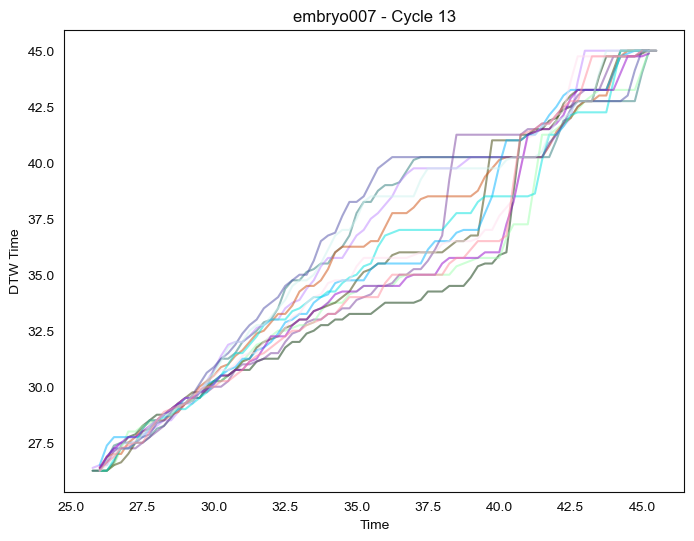

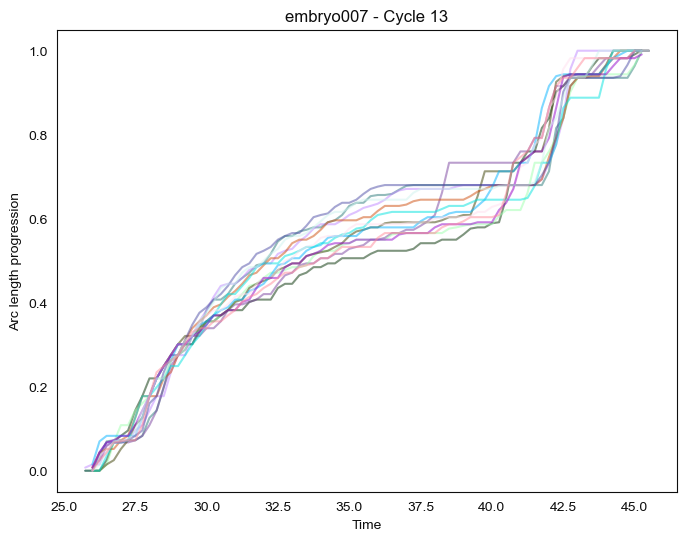

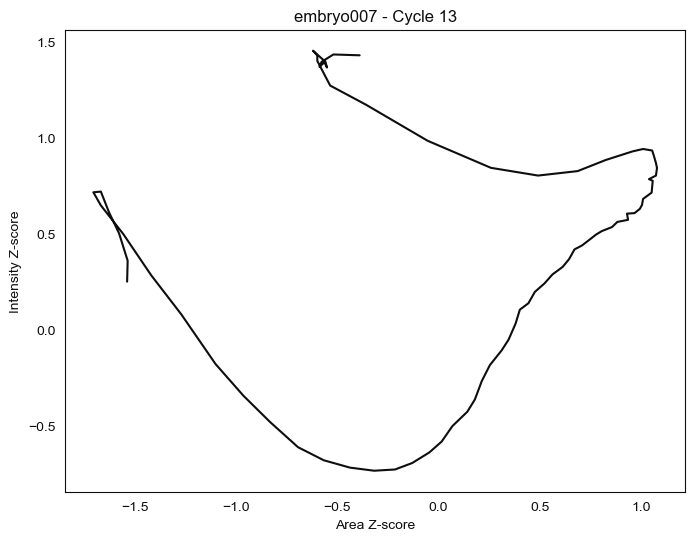

In [20]:
root = "embryo007"
cycle = 13

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cs = cycle_subset[root][cycle_subset[root]["cycle"]==cycle]

sample_ts = cs["tracklet_id"].unique()[1:15]

for t in sample_ts:
    query = cs[cs["tracklet_id"]==t].sort_values(by="time")
    ax.plot(query["time"], query["dtw"], label=t, color=g_palette[t % 256], alpha=0.5)
    
ax.set_xlabel("Time")
ax.set_ylabel("DTW Time")
ax.set_title(f"{root} - Cycle {cycle}")
plt.savefig(plotpath / f"{root}_cycle_{cycle}_dtw_time.png", dpi=300)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for t in sample_ts:
    query = cs[cs["tracklet_id"]==t].sort_values(by="time")
    ax.plot(query["time"], query["arc_length"], label=t, color=g_palette[t % 256], alpha=0.5)
    
ax.set_xlabel("Time")
ax.set_ylabel("Arc length progression")
ax.set_title(f"{root} - Cycle {cycle}")
plt.savefig(plotpath / f"{root}_cycle_{cycle}_arclength_time.png", dpi=300)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
spot_cycle = cycle_subset[root][cycle_subset[root]["cycle"]==cycle].copy()
        
vals = spot_cycle.groupby("time")[["normed_area_root", "normed_intensity_root"]].median()
count = spot_cycle.groupby("time").size()
template = vals[count > count.max()*0.5]

ax.plot(template["normed_area_root"], template["normed_intensity_root"], label="Template", color=palette["black"])

plt.xlabel("Area Z-score")
plt.ylabel("Intensity Z-score")
plt.title(f"{root} - Cycle {cycle}")

plt.show()

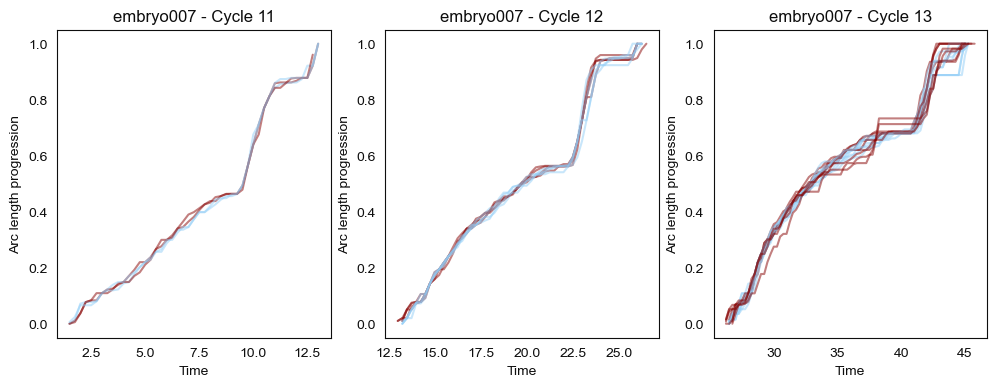

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4))

root = "embryo007"
tracks = cycle_subset[root]["track_id"].unique()[5:7]

for cycle, ax, ax2 in zip([11, 12, 13], axes, axes2):

    cs = cycle_subset[root][cycle_subset[root]["cycle"]==cycle]
    cs = cs[cs["track_id"].isin(tracks)]
    
    tracklet_ids = cs["tracklet_id"].unique()
    
    for t in tracklet_ids:
        query = cs[cs["tracklet_id"]==t].sort_values(by="time")
        track = query["track_id"].iloc[0]
        ax.plot(query["time"], query["arc_length"], label=track, color=g_palette[track + 1 % 256], alpha=0.5)
        ax2
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Arc length progression")
    ax.set_title(f"{root} - Cycle {cycle}")

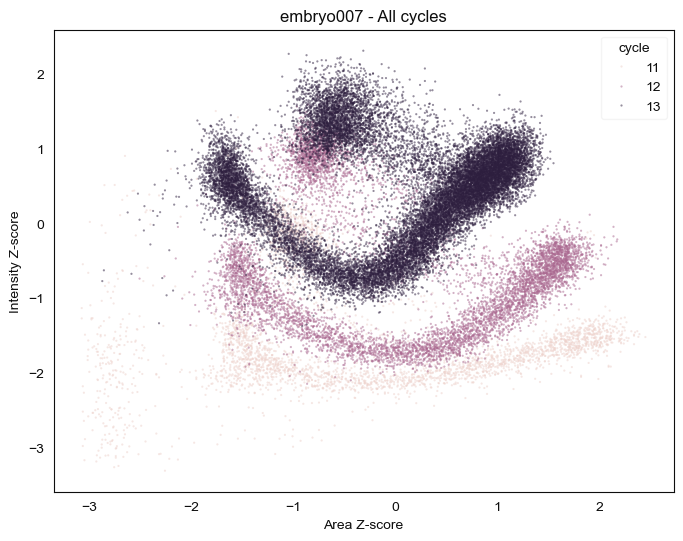

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

root = "embryo007"

sns.scatterplot(data=cycle_subset[root], x="normed_area_root", y="normed_intensity_root", hue="cycle", ax=ax, s=2, edgecolors=None, alpha=0.5)
plt.xlabel("Area Z-score")
plt.ylabel("Intensity Z-score")
plt.title(f"{root} - All cycles")
plt.savefig(plotpath / f"{root}_all_cycles_normed_area_intensity.png", dpi=300)

plt.show()

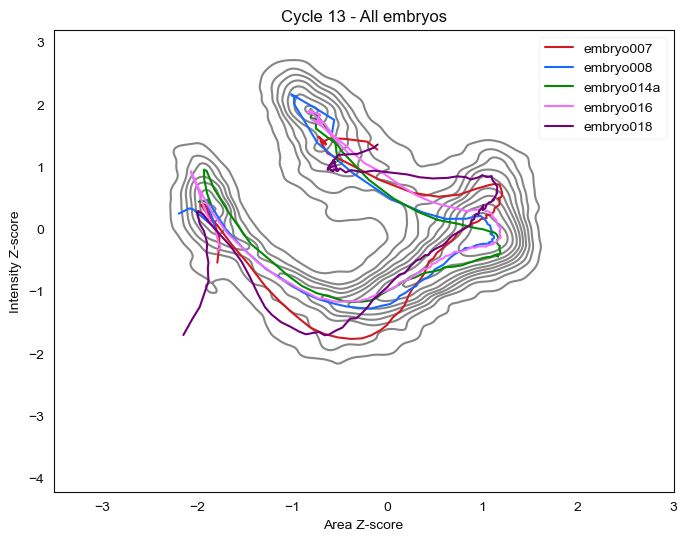

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cycle = 13

full_sample = []

for i, root in enumerate(roots):
    spots = ft_spots[root]
    full_sample.append(spots[spots.cycle == cycle].sample(2500))
    
    # sns.scatterplot(data=sample, x="normed_area", y="normed_intensity_mean", ax=ax, s=4, color=g_palette[i], edgecolors=None, alpha=0.5)
sample = pd.concat(full_sample)
sns.kdeplot(data=sample, x="normed_area", y="normed_intensity_mean", ax=ax, alpha=0.5, bw_adjust=0.4, color = palette["black"])
    
for i, root in enumerate(roots):
    spots = ft_spots[root]
    xs = spots[spots["cycle"]==cycle].groupby("time")[["normed_area", "normed_intensity_mean"]].median()
    count = spots[spots["cycle"]==cycle].groupby("time").size()
    min_xs = xs[count > 15]
    ax.plot(min_xs["normed_area"], min_xs["normed_intensity_mean"], label=root, color=g_palette[i])
    
ax.set_xlabel("Area Z-score")
ax.set_ylabel("Intensity Z-score")
ax.set_title(f"Cycle {cycle} - All embryos")
ax.legend()
plt.savefig(plotpath / f"cycle_{cycle}_all_embryos_normed_area_intensity_kde.png", dpi=300)
plt.show()
    

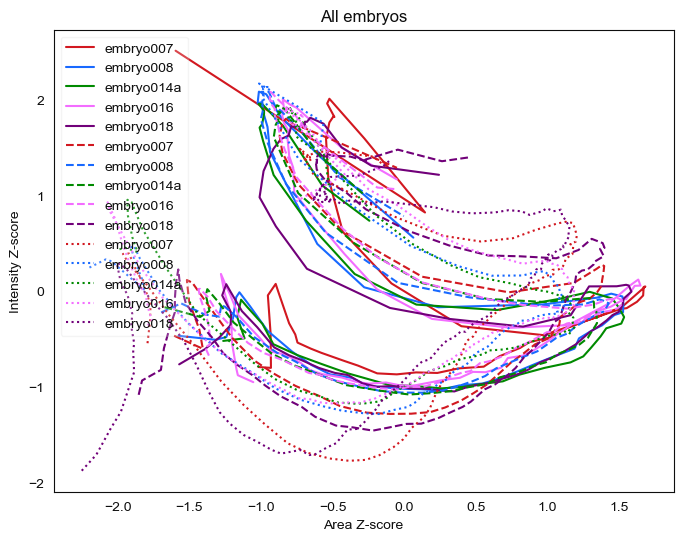

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cycle = 12
lstyle = {11: "-", 12: "--", 13: ":"}

for cycle in [11, 12, 13]:
       
    for i, root in enumerate(roots):
        spots = ft_spots[root]
        xs = spots[spots["cycle"]==cycle].groupby("time")[["normed_area", "normed_intensity_mean"]].median()
        count = spots[spots["cycle"]==cycle].groupby("time").size()
        min_xs = xs[count > 10]
        ax.plot(min_xs["normed_area"], min_xs["normed_intensity_mean"], label=root, color=g_palette[i], linestyle=lstyle[cycle])
    
ax.set_xlabel("Area Z-score")
ax.set_ylabel("Intensity Z-score")
ax.set_title(f"All embryos")
ax.legend()
plt.savefig(plotpath / f"all_cycles_all_embryos_normed_area_intensity.png", dpi=300)
plt.show()